# **RL - Super Mario - Model**

## **_Prerequisites_**



### **install following requirements**
______

#### _Install gym_super_mario_bros for super mario bros environment setup_
> > **pip install gym_super_mario_bros==7.3.0 nes_py**


#### _Install pytorch for RL model training_
> > **pip install torch==1.10.1 torchvision==0.11.2 torchaudio==0.10.1**


#### _Install stable baselines for RL stuff_
> > **pip install stable-baselines3**


#### _Install for graphical representation_
> > **pip install plotly**
______


In [1]:
# !pip install gym_super_mario_bros nes_py torch torchvision torchaudio stable-baselines3 plotly shimmy 
# !pip install nes-py
# !pip install gym-super-mario-bros==7.3.0
# !pip install wheel<0.40.0
# !pip install gym==0.21.0
# !pip install stable-baselines3==1.6.0

In [1]:
# ignore warnings
import warnings
warnings.simplefilter('ignore')
# Imports for game setup
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT
import numpy as np
import torch
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.distributions import Categorical
import random
from tqdm import tqdm


## **1. Setting Up Mario-Env**

In [2]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros2-v1')

In [3]:
print(f"Total Action Space: {env.action_space}")

Total Action Space: Discrete(256)


In [4]:
print(f"SIMPLE_MOVEMENT Action Space: {len(SIMPLE_MOVEMENT)}")
print(f"COMPLEX_MOVEMENT Action Space: {len(COMPLEX_MOVEMENT)}")

SIMPLE_MOVEMENT Action Space: 7
COMPLEX_MOVEMENT Action Space: 12


> Their are 256 Actions in the Action space of Super Mario Bros. 

hence it will be difficult to train an AI model with such number of possibles options . To overcome this problem, we can use a SIMPLE_MOVEMENT action space which comprises of only 7 options of operations the model can suggest to do.

In [5]:
# minimizing the action space / can also be done with two actions move right and jump right
env = JoypadSpace(env, COMPLEX_MOVEMENT)
print(f"Total Action Space after reduction: {env.action_space}")

Total Action Space after reduction: Discrete(12)


In [7]:
import time
# Create a flag - restart or not
done = True
# Loop through each frame in the game
for step in range(1000): 
    # Start the game to begin with 
    if done: 
        # Start the gamee
        env.reset()
    # Do random actions
    state, reward, done, info  = env.step(env.action_space.sample())
    # Show the game on the screen
    env.render()
    # time.sleep(0.01)
# Close the game
env.close()

2024-04-17 13:32:04.098 Python[22717:931214] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/jw/lz3gc5915cxgsvv61ql8_83c0000gn/T/com.apple.python3.savedState


: 

## **2. Preprocess Environment**

In [7]:
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

In [8]:
# 1. Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros2-v1')
# 2. Simplify the controls 
env = JoypadSpace(env, COMPLEX_MOVEMENT)
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')


state = env.reset()

# Taking a random action
action = env.action_space.sample()
state, reward, done, info = env.step([action])

print("Observation shape:", state.shape)
print("Information:", info)
print("Game End Status:", done)

Observation shape: (1, 240, 256, 4)
Information: [{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}]
Game End Status: [False]


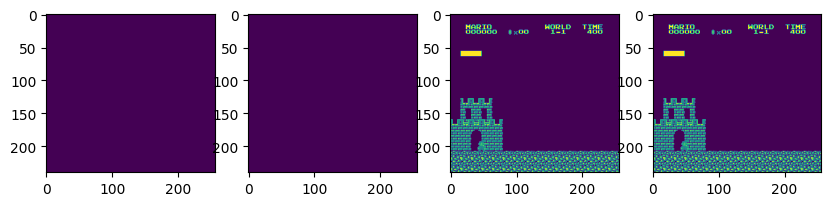

In [9]:
plt.figure(figsize=(10,8))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

## **3. Training the RL Models**


In [10]:
import os 
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [11]:
#  making a training logger to save the model checkpoints after set frequency
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    # making the checkpoint directory
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
    
    # on every step checking if the check_frequency is reached, save the model
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [12]:
# Initializing the AI model
# PPO Parameters
    # policy: Union[str, Type[ActorCriticPolicy]],
    # env: Union[GymEnv, str],
    # learning_rate: Union[float, Schedule] = 3e-4,
    # n_steps: int = 2048,
    # batch_size: int = 64,
    # n_epochs: int = 10,
    # gamma: float = 0.99,
    # gae_lambda: float = 0.95,
    # clip_range: Union[float, Schedule] = 0.2,
    # clip_range_vf: Union[None, float, Schedule] = None,
    # normalize_advantage: bool = True,
    # ent_coef: float = 0.0,
    # vf_coef: float = 0.5,
    # max_grad_norm: float = 0.5,
    # use_sde: bool = False,
    # sde_sample_freq: int = -1,
    # target_kl: Optional[float] = None,
    # tensorboard_log: Optional[str] = None,
    # create_eval_env: bool = False,
    # policy_kwargs: Optional[Dict[str, Any]] = None,
    # verbose: int = 0,
    # seed: Optional[int] = None,
    # device: Union[th.device, str] = "auto",
    # _init_setup_model: bool = True,

In [13]:
# setting logs dir for tensorboard
LOG_DIR = './logs/'
# setting the available device for training
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

### **1. Cnn Policy Agent**

In [31]:
CHECKPOINT_DIR = './train/'
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)
seed = 42
model = PPO('CnnPolicy',
            env,
            learning_rate=0.0001,
            n_steps=10240,
            batch_size=256,
            n_epochs=10,
            tensorboard_log=LOG_DIR,
            verbose=1,
            seed=seed,
            device=device)
model.policy

Using mps device
Wrapping the env in a VecTransposeImage.


ActorCriticCnnPolicy(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=46592, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential()
    (policy_net): Sequential()
    (value_net): Sequential()
  )
  (action_net): Linear(in_features=512, out_features=7, bias=True)
  (value_net): Linear(in_features=512, out_features=1, bias=True)
)

In [17]:
model.learn(total_timesteps=102400, callback=callback)

Using mps device
Wrapping the env in a VecTransposeImage.
Logging to ./logs/PPO_3


/Users/abdulwadood/Library/Python/3.9/lib/python/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


------------------------------
| time/              |       |
|    fps             | 128   |
|    iterations      | 1     |
|    time_elapsed    | 79    |
|    total_timesteps | 10240 |
------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 83        |
|    iterations           | 2         |
|    time_elapsed         | 245       |
|    total_timesteps      | 20480     |
| train/                  |           |
|    approx_kl            | 0.0199751 |
|    clip_fraction        | 0.209     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.93     |
|    explained_variance   | -0.00579  |
|    learning_rate        | 0.0001    |
|    loss                 | 0.545     |
|    n_updates            | 10        |
|    policy_gradient_loss | -0.00509  |
|    value_loss           | 1.88      |
---------------------------------------
----------------------------------------
| time/               

In [18]:
# saving the final model
model.save("CnnPolicy")

### **2. MlpPolicy Agent**

In [30]:
CHECKPOINT_DIR = './train2/'
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)
seed = 42
model = PPO('MlpPolicy',
            env,
            learning_rate=0.0001,
            n_steps=10240,
            batch_size=256,
            n_epochs=10,
            tensorboard_log=LOG_DIR,
            verbose=1,
            seed=seed,
            device=device)
model.policy

Using mps device
Wrapping the env in a VecTransposeImage.


ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential()
    (policy_net): Sequential(
      (0): Linear(in_features=245760, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=245760, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=7, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)

In [25]:
model.learn(total_timesteps=102400, callback=callback)

Using cpu device
Wrapping the env in a VecTransposeImage.
Logging to ./logs/PPO_5
------------------------------
| time/              |       |
|    fps             | 167   |
|    iterations      | 1     |
|    time_elapsed    | 61    |
|    total_timesteps | 10240 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 116         |
|    iterations           | 2           |
|    time_elapsed         | 175         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.004726039 |
|    clip_fraction        | 0.00182     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | 0.0259      |
|    learning_rate        | 0.0001      |
|    loss                 | 20.4        |
|    n_updates            | 5           |
|    policy_gradient_loss | -0.00314    |
|    value_loss           | 3

In [26]:
# saving the final model
model.save("MlpPolicy")

### **3. CNN Agent (Custom)**

In [23]:
class CustomCNN(nn.Module):
    def __init__(self, num_actions):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(26*28*64, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.policy_head = nn.Linear(128, num_actions)
        self.value_head = nn.Linear(128, 1)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = x.reshape(x.size(0), -1) # Flatten the tensor
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        policy_logits = self.policy_head(x)
        value = self.value_head(x)
        return policy_logits, value

In [24]:
# Assuming CustomCNN and env are defined and initialized
model = CustomCNN(num_actions=env.action_space.n).to(device=device)
optimizer = Adam(model.parameters(), lr=0.000001)
model

CustomCNN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46592, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (policy_head): Linear(in_features=128, out_features=12, bias=True)
  (value_head): Linear(in_features=128, out_features=1, bias=True)
)

In [27]:
num_episodes = 100 # Number of episodes to train for
gamma = 0.99 # Discount factor for future rewards
max_steps_per_episode = 1000
batch_size = 256
for episode in range(num_episodes):
    obs = env.reset()
    done = False
    episode_reward = 0
    experiences = [] # List to store experiences

    pbar = tqdm(total=max_steps_per_episode, desc=f"Episode {episode+1}/{num_episodes}: training")
    
    while not done and len(experiences) < max_steps_per_episode:
        # Convert observation to tensor
        obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device).permute(0,3,1,2)
        
        # Forward pass through the model to get policy logits and value
        policy_logits, value = model(obs_tensor)
        
        # Sample action from the policy
        action_probs = torch.nn.functional.softmax(policy_logits, dim=-1)
        action = torch.multinomial(action_probs, 1).item()
        
        # Take the action in the environment
        next_obs, reward, done, info = env.step([action])
        
        # Store the experience for loss calculation
        experiences.append((obs_tensor, action, reward, torch.tensor(next_obs, dtype=torch.float32).unsqueeze(0), done))
        
        obs = next_obs
        
        # Accumulating the reward
        episode_reward += reward
        
        # updating the tqdm loading
        pbar.update(1)
    loss = 0
    # Calculate the loss and update the model
    for obs, action, reward, next_obs, done in random.sample(experiences, batch_size):
        # Forward pass through the model to get policy logits and value for the current state
        policy_logits, value = model(obs)
        
        # Forward pass through the model to get policy logits and value for the next state
        next_obs = next_obs.squeeze(0).permute(0,3,1,2).to(device=device)
        next_policy_logits, next_value = model(next_obs)
        
        # Calculate the advantage
        reward = torch.tensor(reward, dtype=torch.float32, device=device)

        # Assuming gamma is a scalar or a PyTorch tensor
        gamma = torch.tensor(gamma, dtype=torch.float32, device=device)

        # Ensure next_value and value are tensors
        next_value = torch.tensor(next_value, dtype=torch.float32, device=device)
        value = torch.tensor(value, dtype=torch.float32, device=device)

        advantage = reward + gamma * next_value - value
        
        # Calculate the PPO loss
        old_log_probs = torch.nn.functional.log_softmax(policy_logits, dim=-1)
        new_log_probs = torch.nn.functional.log_softmax(next_policy_logits, dim=-1)
        ratio = torch.exp(new_log_probs - old_log_probs)
        surr1 = ratio * advantage
        surr2 = torch.clamp(ratio, 1.0 - 0.2, 1.0 + 0.2) * advantage
        loss += -torch.min(surr1, surr2) + 0.5 * nn.MSELoss()(value, next_value)
        

    optimizer.zero_grad()
    # Perform a backward pass
    loss.mean().backward()
    # Update the model parameters
    optimizer.step()

    # tqdm stuff updating
    pbar.set_description(f"Episode {episode+1}: Total Reward = {episode_reward}, Loss = {loss.mean():.4f}")
    pbar.update(1000)
    pbar.close()


Episode 1: Total Reward = [-93.], Loss = 20.1188: : 1841it [00:10, 177.55it/s]
Episode 2: Total Reward = [-1.], Loss = 4.5736: : 2000it [00:10, 196.53it/s]                        
Episode 3: Total Reward = [-97.], Loss = 45.1005: : 2000it [00:10, 197.88it/s]                        
Episode 4: Total Reward = [-111.], Loss = 38.1171: : 1899it [00:09, 196.91it/s]                       
Episode 5: Total Reward = [-102.], Loss = 34.1829: : 1877it [00:09, 197.70it/s]                       
Episode 6: Total Reward = [97.], Loss = -29.7414: : 2000it [00:10, 196.15it/s]                        
Episode 7: Total Reward = [-63.], Loss = 31.2623: : 2000it [00:10, 190.70it/s]                        
Episode 8: Total Reward = [-114.], Loss = 33.3134: : 2000it [00:10, 197.93it/s]                        
Episode 9: Total Reward = [-16.], Loss = -6.9522: : 2000it [00:10, 197.09it/s]                        
Episode 10: Total Reward = [-82.], Loss = 23.9595: : 2000it [00:10, 198.68it/s]                   

In [28]:
# Save the model
torch.save(model.state_dict(), 'CustomCNN.pth')

## **4. Evaluating the RL Agents**

In [36]:
# evaluation criteria 
def evaluate_agent(agent, episodes=5):
    # list to store rewards
    total_rewards = []
    for episode in range(episodes):
        # resetting the env so the game start from beginning.
        state = env.reset()
        total_reward = 0
        done = False
        # while game is not ended
        while not done:
            try:
                action, _ = agent.predict(state)
            except:
                action, _ = agent(torch.tensor(state, dtype=torch.float32).to(device).permute(0, 3, 1, 2))
                action = [torch.argmax(action).item()]
            next_state, reward, done, _ = env.step(action)
            state = next_state
            # Commutative sum of reward
            total_reward += reward
        total_rewards.append(total_reward)
        # total rewards per episode
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")
    # average rewards over all episodes
    avg_reward = np.mean(total_rewards)
    print(f"Average Reward: {avg_reward}")
    return avg_reward

In [22]:
model = PPO.load("CnnPolicy")
avg_cnn_reward = evaluate_agent(model)
avg_cnn_reward

Episode 1/5, Total Reward: [450.]
Episode 2/5, Total Reward: [389.]
Episode 3/5, Total Reward: [396.]
Episode 4/5, Total Reward: [231.]
Episode 5/5, Total Reward: [391.]
Average Reward: 371.3999938964844


371.4

In [27]:
model = PPO.load("MlpPolicy")
avg_mlp_reward = evaluate_agent(model)

Episode 1/5, Total Reward: [411.]
Episode 2/5, Total Reward: [402.]
Episode 3/5, Total Reward: [403.]
Episode 4/5, Total Reward: [397.]
Episode 5/5, Total Reward: [451.]
Average Reward: 412.79998779296875


In [37]:
model = CustomCNN(num_actions=env.action_space.n)

# Load the model
model.load_state_dict(torch.load('CustomCNN.pth'))
model = model.to("mps")
model.eval()
avg_CustomCnn_reward = evaluate_agent(model)

Episode 1/5, Total Reward: [330.]
Episode 2/5, Total Reward: [330.]
Episode 3/5, Total Reward: [330.]
Episode 4/5, Total Reward: [330.]
Episode 5/5, Total Reward: [330.]
Average Reward: 330.0


## **5. Testing it Out**

In [40]:
# Loading best model
# model = PPO.load('MlpPolicy') if avg_mlp_reward > avg_cnn_reward else PPO.load("CnnPolicy")
model = PPO.load('MlpPolicy')
model.policy

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential()
    (policy_net): Sequential(
      (0): Linear(in_features=245760, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=245760, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=7, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)

In [41]:
# Start the game 
state = env.reset()
done = False
# Loop through the game
while not done: 
    # model prediction for action space
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    # rendering the game
    env.render(mode="human")

2024-04-17 13:26:03.296 Python[9832:882773] Warning: Window move completed without beginning


_________